# Recurrence plot
### Ana Daniela del Río Pulido and Erin C. McKiernan
## Facultad de Ciencias, UNAM

If you have not seen the notebook on attractor reconstruction, be sure to start from there. The objective of this notebook is to understand how a recurrence plot is constructed and identifying what kind of information can be extracted from it. Also, students will be able to identify the limitations of this technique.

## False neighbors
Let us suppose we reconstructed the heart's attractor in phase space in 2 dimensions. Then we got a figure like the following:
<img src="Images/S1_125.png" width ="400" height ="100" > 

How do you know that two points that lie near in phase space are actually true neighbors in this mathematical space? In other words, what if they are **false neighbors**? To solve this problem, you go up a dimension, that is in this example, 3 dimensions.
<img src="Images/3d4.png" width ="400" height ="100" > 

Now, consider the distance between two points in the 2D representation, if these points lie "farther away" in the 3D representation, then they were false neighbors. We can formalize this idea by taking the norm between the points in 3D, if this norm is greater than a certain $r$ value, then these two points were false neighbors. 


Disclaimer: the example was set in 2 and 3 dimensions for the sake of visual representations. The attractor could be in $n$ dimensions.


Now we want to link this with recurrence plots. For constructing a recurrence plot, you must know beforehand the dimension of the attractor. Then, you consider an $\epsilon$-neighborhood around a point of the attractor. Every point that lies on the $\epsilon$-neighborhood of our point will be assigned a value of 1. And every point that lies outside the $\epsilon$-neighborhood of our point will be assigned a value of 0. For a visual representation, see the following figure.

<img src="Images/yang_2016_chapter_nonlinear_dynamics_fig3-11.jpg" width ="300" height ="100" >

With this technique, interesting patterns emerge with certain kinds of signals. For example see the following figure where the time series is plotted on the top row and in the bottom the recurrence plots. From left to right: uncorrelated stochastic data (white noise), harmonic oscillation with two frequencies, chaotic data with linear trend (logistic map) and data from an auto-regressive process.

<img src="Images/recurrence_plots.gif" width ="600" height ="200" > 

Recurrence plots. Image taken from Norbert Marwan, Pucicu at English Wikipedia, CC BY-SA 3.0, 10 October 2006, https://upload.wikimedia.org/wikipedia/commons/4/46/Rp_examples740.gif


The big drawback here is that we are not sure of the true dimensionality of the attractor. Besides, when reconstructing it, we are arbitrarily choosing the time lags and based on this is the attractor we obtain.

All this to say that some of the patterns obtained in the recurrence plot may be false neighbors due to the technique used for obtaining the attractor. Nevertheless, the technique will be clear with the following notebook.

# Setting up the notebook

We begin by setting up the Jupyter notebook and importing the Python modules needed for plotting figures, create animations, etc. We include commands to view plots in the Jupyter notebook, and to create figures with good resolution and large labels. These commands can be customized to produce figures with other specifications.

In [1]:
# Imports python libraries
import numpy as np
import random as rd
import wave
import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
sys.path.insert(1, r'./../functions') # add to pythonpath

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting

## Extracting and graphing the data

ECG recordings were obtained using the Backyard Brains Heart and Brain Spiker Box. The recordings are saved as audio files in .wav format. The first thing we have to do is open the .wav files and extract the data. We can extract the number of recording channels, sampling rate, etc.

In [2]:
#Function that extracts the number of recording channels, sampling rate, time and signal
#variable is the path and filename of the .wav file
def ecg(variable):
    record = wave.open(variable, 'r') # load the data

    # Get the number of channels, sample rate, etc.
    numChannels = record.getnchannels() #number of channels
    numFrames = record.getnframes() #number of frames
    sampleRate = record.getframerate() #sampling rate
    sampleWidth = record.getsampwidth()
    
    # Get wave data
    dstr = record.readframes(numFrames * numChannels)
    waveData = np.frombuffer(dstr, np.int16)

    # Get time window
    timeECG = np.linspace(0, len(waveData)/sampleRate, num=len(waveData))

    return timeECG, waveData

The following function obtains the indices when a local maximum occurs in the time series. 

In [3]:
def detects_local_maximums(timeECG, waveData, threshold_ratio=0.7):
    # If not all the R peaks are detected, lower the threshold_ratio
    # If components that are not R peaks (like T waves) are detected, higher the threshold_ratio

    if len(timeECG) != len(waveData): #Raises an error if the two arrays have different lengths
        raise Exception("The two arrays have different lengths.")
    
    interval = max(waveData) - min(waveData)
    threshold = threshold_ratio*interval + min(waveData)
    maxima = []
    maxima_indices = []
    mxs_indices = []
    banner = False
    
    for i in range(0, len(waveData)):
            
        if waveData[i] >= threshold:#If a threshold value is surpassed,
            # the indices and values are saved 
            banner = True
            maxima_indices.append(i)
            maxima.append(waveData[i])
            
        elif banner == True and waveData[i] < threshold: #If the threshold value is crossed
            # the index of the maximum value in the original array is saved
            index_local_max = maxima.index(max(maxima))
            mxs_indices.append(maxima_indices[index_local_max])
            maxima = []
            maxima_indices = []
            banner = False     

    return mxs_indices

Obtaining the signal we will use

In [4]:
timeECG, waveData = ecg("ECG_samples/S4_rest.wav")

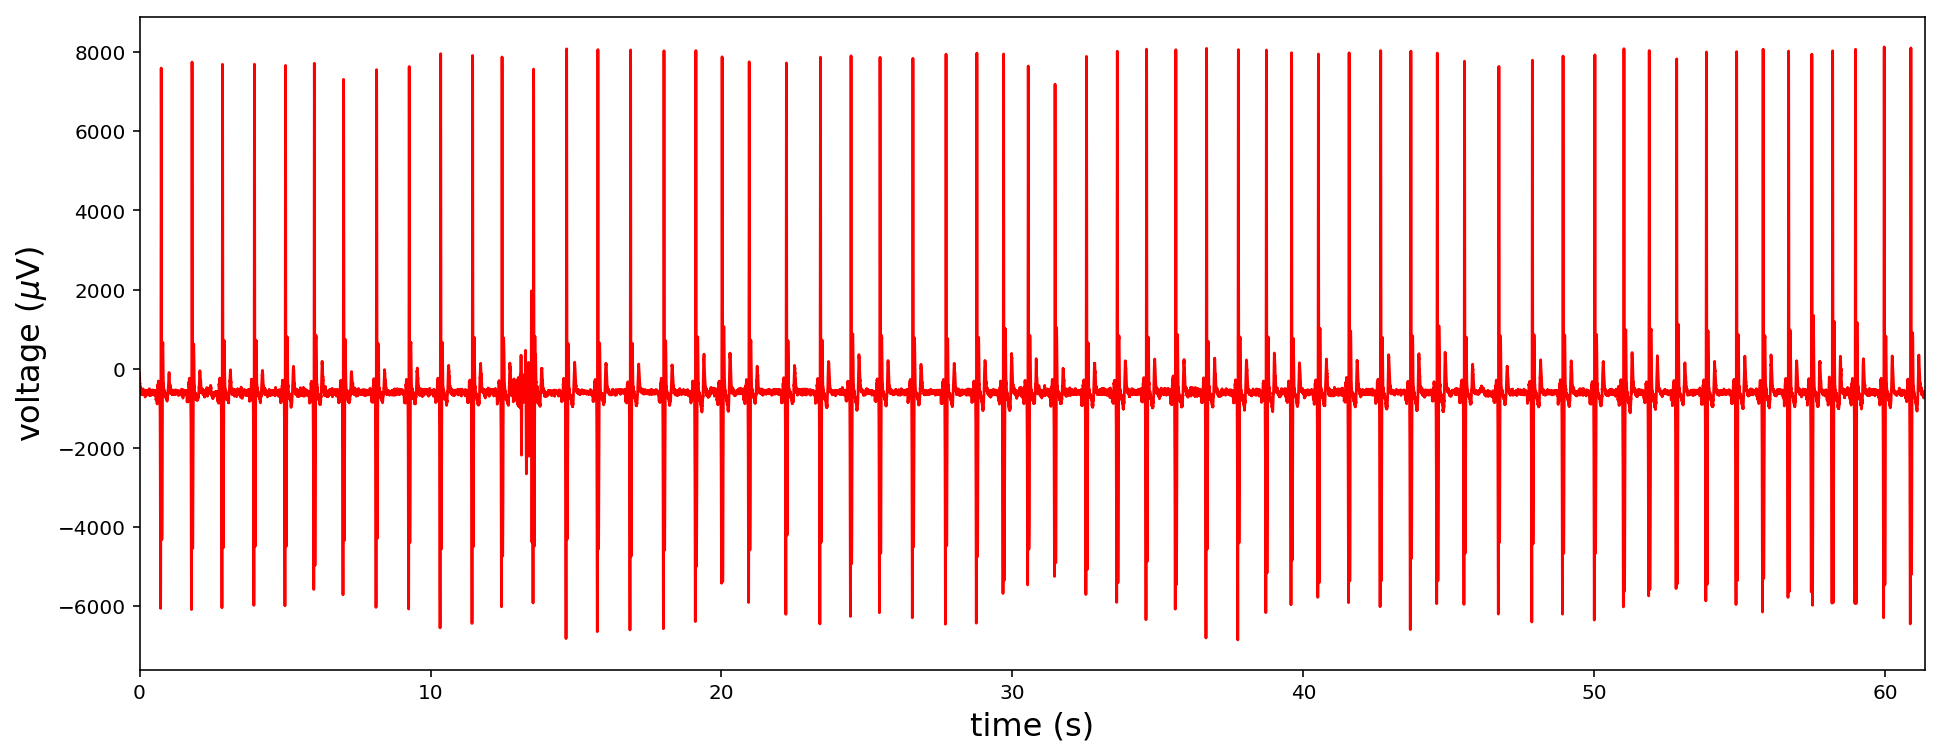

In [5]:
#Plots R peaks and ECG signal
plt.figure(figsize=(16,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(min(timeECG),max(timeECG))
plt.plot(timeECG, waveData, c="r")
plt.show()

What is the sampling rate of the previous recording?

In [6]:
print(len(waveData)/timeECG[-1], " points per second")

10000.0  points per second


Obtaining a recurrence plot is a very slow process because we are obtaining the distance between every two points in the time series in phase space. In this case, the sampling rate is high, so we can decide to use less points for obtaining the recurrence plot. Currently, the sampling rate is 10 000 samples per second. We want to obtain two cycles (starting from baseline and capturing the QRS complex) and have less number of points representing these cycles. This is why will create the surrogate data.

Make sure when generating the surrogate data to start the data just before a QRS complex occurs and end it just after a QRS complex happens.

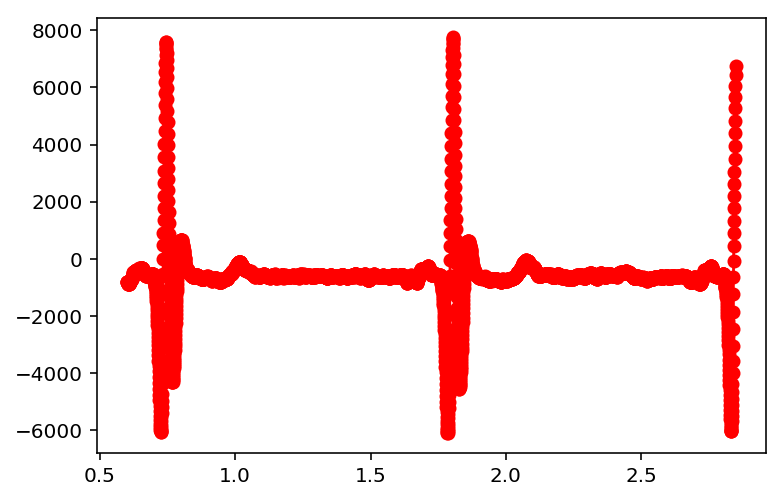

In [7]:
initial_point = 1000
sample_points = 6500

#Creating the surrogate time series
surrogate = [waveData[initial_point+i*5] for i in range(initial_point, sample_points-initial_point)]
time_surrogate = [timeECG[initial_point+i*5] for i in range(initial_point, sample_points-initial_point)]

plt.plot(time_surrogate, surrogate, marker="o", c="r")
plt.show()

### Exercise: What is the index in the surrogate data that corresponds to the 12.5 miliseconds? Change the values of ``a`` and ``b`` to obtain 12.5 in the time series interval

In [8]:
a = 1
b = 2

print("Original time series interval in miliseconds: ",(timeECG[a]-timeECG[0])*1000)
print("Surrogate time series interval in miliseconds: ",(time_surrogate[b]-time_surrogate[0])*1000)

Original time series interval in miliseconds:  0.10000016296305954
Surrogate time series interval in miliseconds:  1.0000016296305425


If you are having trouble with the previous exercise, try $a$ near 100 and $b$ near 30.

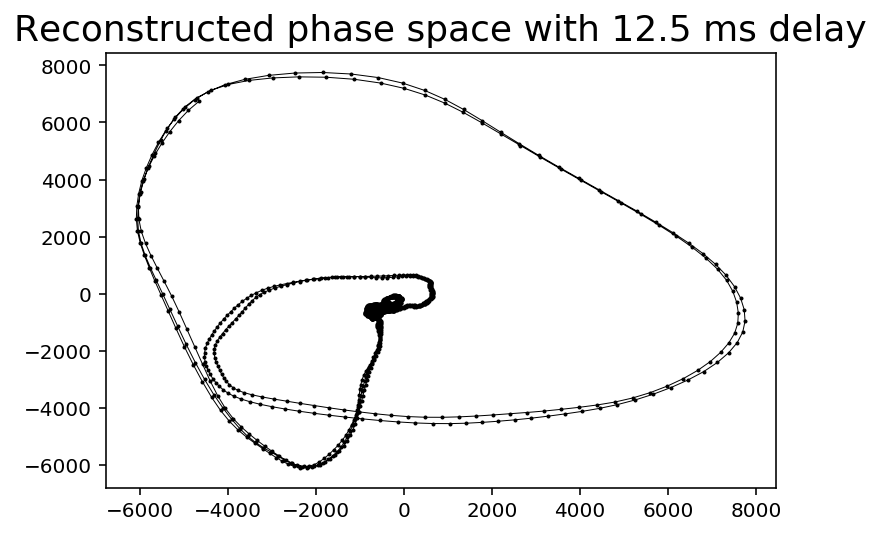

In [9]:
n = np.size(surrogate)
delay = 25

plt.plot(surrogate[0: n-delay], surrogate[delay: n],
          marker = "o", markersize = 1, linewidth = 0.5, color = "black")
plt.title("Reconstructed phase space with 12.5 ms delay")
plt.show()

Let us create our first recurrence plot! We want to obtain the norm between any two dots in phase space. If the distance is less than a certain epsilon, we will assign a value of 1, if not, 0. A heads up, the following cell will take some time, in my computer it lasted around 3 minutes.

In [10]:
# Binary Recurrence plot
epsilon = 300
delay = 25
n = len(surrogate)
bin_mat = np.zeros((n,n), dtype = 'bool')

for i in range(0, n-delay):
    for j in range(delay, n):
        if np.sqrt(np.abs(surrogate[i]**2 - surrogate[j]**2)) < epsilon:
            #euclidian norm less than epsilon, or the Heaviside function
            bin_mat[i][j] = True

In [11]:
# Generating the indices for the surrogate data
index_surrogate = [i for i in range(0, len(surrogate))]

Plotting our first recurrence plot

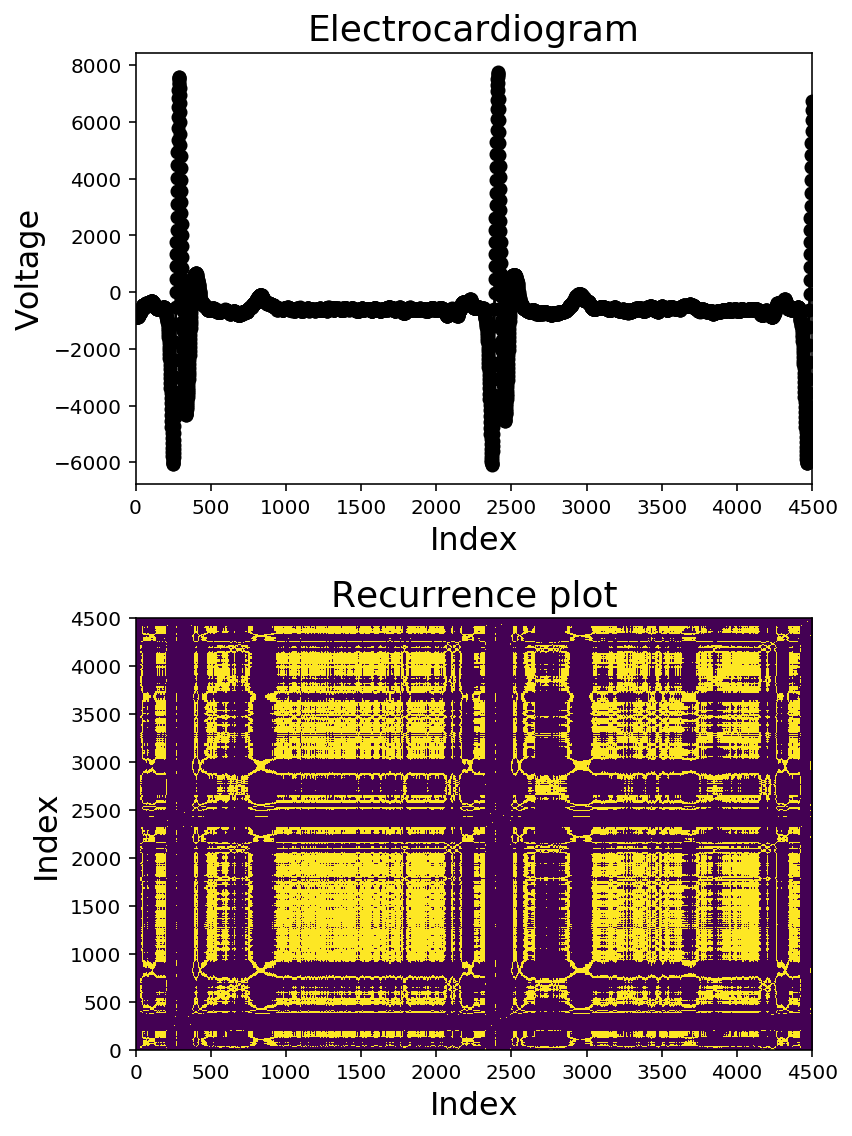

In [12]:
#Initializing the graphic space
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

# Electrocardiogram
ax1.set_title("Electrocardiogram")
ax1.set_ylabel('Voltage')
ax1.set_xlabel('Index')
ax1.set_xlim(0, len(surrogate))
ax1.plot(index_surrogate, surrogate, marker="o", c="k") #index_surrogate or time_surrogate (ms)

# Reconstruction of attractor in phase space
# ax1.plot(surrogate[0: n-delay], surrogate[delay: n],
#           marker = "o", markersize = 0.05, linewidth = 0.005, color = "black")

# Diagrama de recurrencia
ax2.set_title("Recurrence plot")
ax2.set_ylabel('Index')
ax2.set_xlabel('Index')
ax2.imshow(bin_mat, origin='lower', aspect="auto")
fig.tight_layout()

Remember that in a recurrence plot, we compare the distance in phase space of every point to every other one. Notice that points that lie near each other in phase space are represented by yellow dots. In the ECG, these points lie near the baseline. When QRS complexes occur, the distance between the plots is larger, which is when the purple zones appear.

### Exercise: What do you think will happen if you try using different epsilons? And if you change the delay for reconstructing phase space? Modify the following cell with the appropriate changes.

In [14]:
time_delays = []
epsilons = []
n = len(surrogate)

for epsilon in epsilons:
    
    bin_mat = np.zeros((n,n), dtype = 'bool') #Creating a binary matrix

    for i in range(0, n-time_delays[0]): #Is the time_delays index correct?  Is a for cycle missing?
        for j in range(time_delays[0], n):
            if np.sqrt(surrogate[i]**2 - surrogate[j]**2) != epsilon: #Is the norm different than epsilon?
                bin_mat[i][j] = True
                
        if i%1000 == 0: # Counter to see in which step is the computer
            print(i)
    plt.title(epsilon)
    plt.imshow(bin_mat, origin='lower')
    plt.show()

# Recurrence plot with heat map

At the beginning we mentioned an $\epsilon$-neighborhood around a certain point and values of 1 or 0 depending if the other points were inside or not this neighborhood. Instead of these binary values, what if we normalize the distance by the biggest distance possible between two points? In this manner, we will obtain a recurrence plot with colors of a heatmap, depending if the points are near or far away. Notice that the following part will also take a while to run.

In [14]:
# Heat map Recurrence plot
delay = 25
n = len(surrogate)
euclid = np.zeros((n,n), dtype = 'float')
normal_euclid_rest = np.zeros((n,n), dtype = 'float')

#Cycle for obtaining the euclid distance between any two points
for i in range(0, n-delay):
    for j in range(delay, n):
        euclid[i][j] = np.sqrt(np.abs(surrogate[i]**2 - surrogate[j]**2)) #euclidian norm

normal_aux = np.max(euclid)
                         
# Cycle for normalizing the distance
for i in range(0, n-delay):
    for j in range(delay, n):
        normal_euclid_rest[i][j] = np.abs(euclid[i][j]/normal_aux-1)
        #Normalizing the values, and the farthest points have the lowest value (0),
        #while the nearest points have a value near 1

#Creating a vector with the indices for the surrogate data
index_surrogate = [i for i in range(0, len(surrogate))]

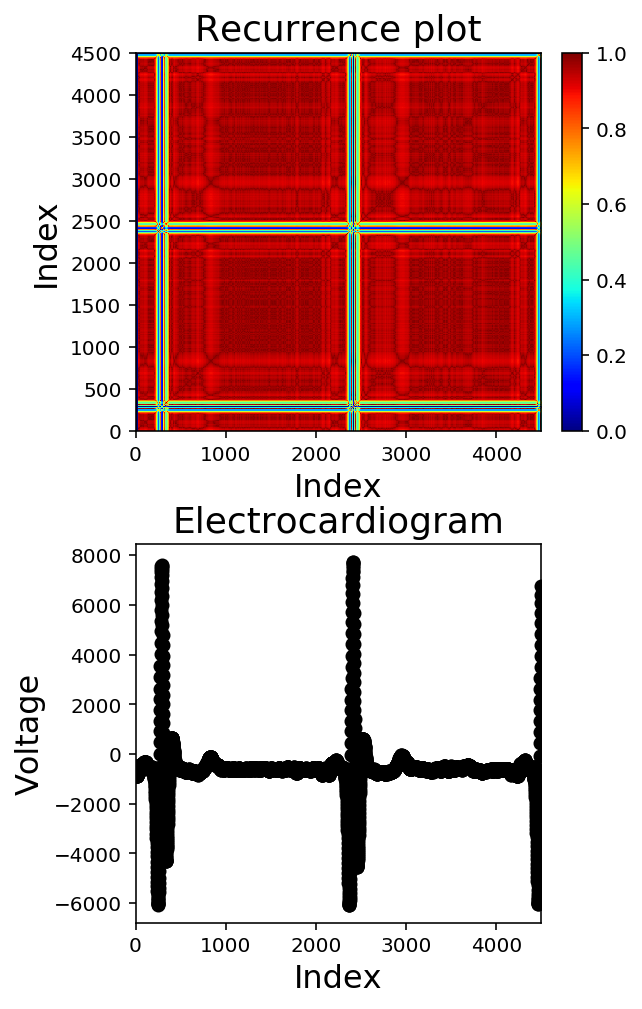

In [24]:
#Initializing the graphic space
fig = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[2, 1], wspace=0.2, hspace=0.3)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 0], sharex=ax1)
plt.tick_params(which='both', top=False, right=False)
ax2.set_autoscalex_on(False)

ax1.set_title("Electrocardiogram")
ax1.set_ylabel('Voltage')
ax1.set_xlabel('Index')
ax1.set_xlim(0, len(surrogate))
ax1.plot(index_surrogate, surrogate, marker="o", c="k") #index_surrogate or time_surrogate (ms)

ax2.set_title("Recurrence plot")
ax2.set_ylabel('Index')
ax2.set_xlabel('Index')
plot = ax2.imshow(normal_euclid_rest, origin='lower', aspect="auto", cmap="jet")
axins = inset_axes(ax2,
               width="5%", # width = 10% of parent_bbox width
               height="100%", # height : 50%
               loc=6,
               bbox_to_anchor=(1.05, 0., 1, 1),
               bbox_transform=ax2.transAxes,
               borderpad=0,)

cbar = plt.colorbar(plot, cax=axins)
plt.show()

Notice that this technique limits only being able to analyze two cycles due to all the calculations that must be done. In the previous graph you can compare what is happening in the electrocardiogram signal compared with its distance in phase space to every other point in the ECG. This is why the QRS complexes are very far away in phase space, which corresponds to a distance of almost zero. The rest of the signal lies near in phase space which is a distance of more than 0.8 in the previous recurrence plot.

### Exercise: Consider you have an attractor in 4 dimensions (you can simulate this using several time delays in each direction using the same time series), write a code to obtain the recurrence plot with a heatmap of this attractor.

# What happens to the recurrence plot after exercise?

In [16]:
timeECG_exer, waveData_exer = ecg("ECG_samples/S4_exercise.wav")

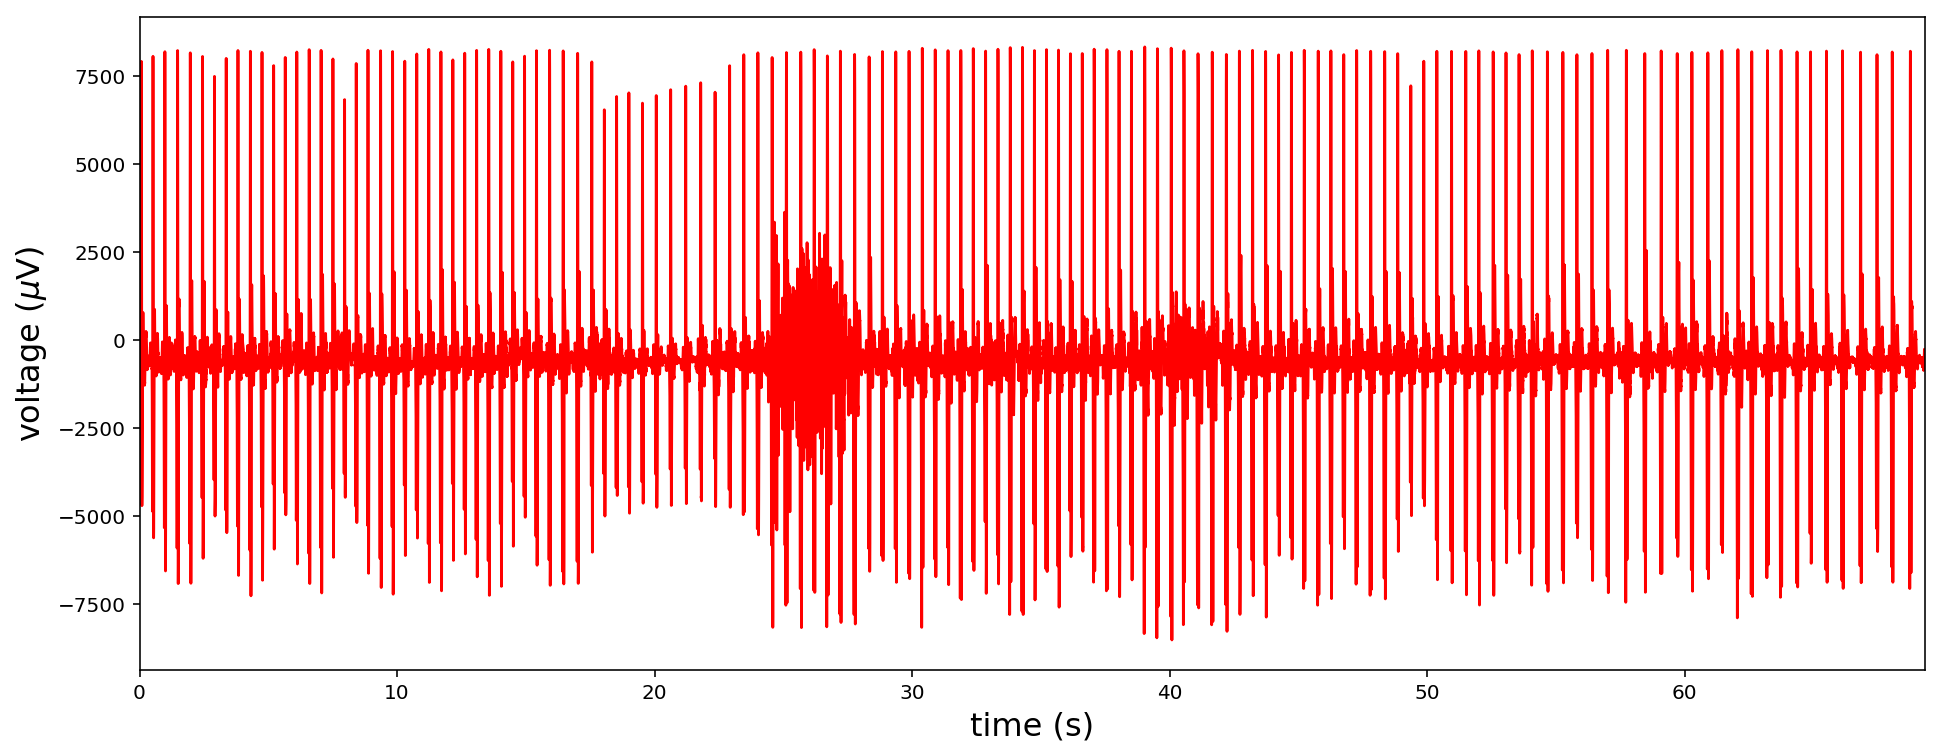

In [17]:
#Plots R peaks and ECG signal
plt.figure(figsize=(16,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(min(timeECG_exer), max(timeECG_exer))
plt.plot(timeECG_exer, waveData_exer, c="r")
plt.show()

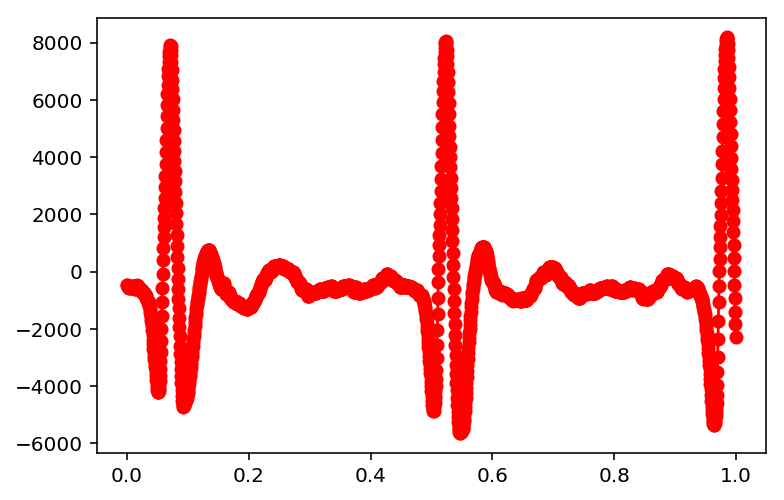

In [18]:
initial_point = 0
sample_points = 2000

#Creating the surrogate time series
surrogate_exer = [waveData_exer[initial_point+i*5] for i in range(initial_point, sample_points-initial_point)]
time_surrogate_exer = [timeECG_exer[initial_point+i*5] for i in range(initial_point, sample_points-initial_point)]

plt.plot(time_surrogate_exer, surrogate_exer, marker="o", c="r")
plt.show()

Notice that the sampling rate is the same as in the first recording, 10000 points per second.

In [19]:
print(len(waveData_exer)/timeECG_exer[-1], " points per second")

10000.0  points per second


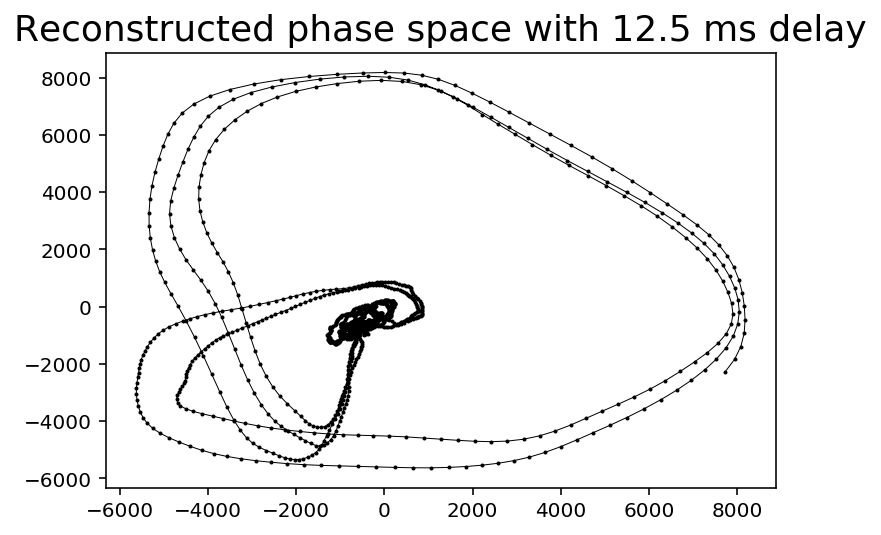

In [20]:
n = np.size(surrogate_exer)
delay = 25

plt.plot(surrogate_exer[0: n-delay], surrogate_exer[delay: n],
          marker = "o", markersize = 1, linewidth = 0.5, color = "black")
plt.title("Reconstructed phase space with 12.5 ms delay")
plt.show()

In [21]:
# Heat map Recurrence plot
delay = 25
n = len(surrogate_exer)
euclid = np.zeros((n,n), dtype = 'float')
normal_euclid_exer = np.zeros((n,n), dtype = 'float')

#Cycle for obtaining the euclid distance between any two points
for i in range(0, n-delay):
    for j in range(delay, n):
        euclid[i][j] = np.sqrt(np.abs(surrogate_exer[i]**2 - surrogate_exer[j]**2)) #euclidian norm

# We will use the same normalization as in te previous recurrence plot: normal_aux

# Cycle for normalizing the distance
for i in range(0, n-delay):
    for j in range(delay, n):
        normal_euclid_exer[i][j] = np.abs(euclid[i][j]/normal_aux-1)
        #Normalizing the values, and the farthest points have the lowest value (0),
        #while the nearest points have a value near 1
        
#Creating a vector with the indices for the surrogate data
index_surrogate_exer = [i for i in range(0, len(surrogate_exer))]

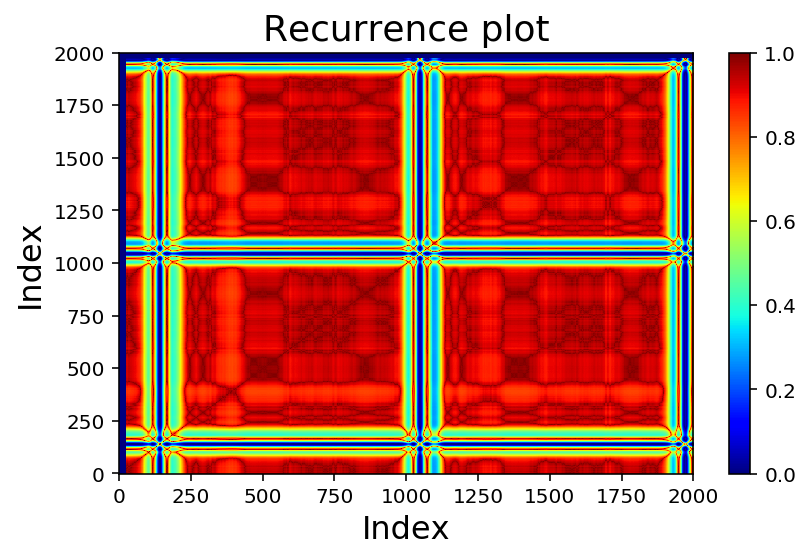

In [22]:
plt.figure()
plt.title("Recurrence plot")
plt.ylabel('Index')
plt.xlabel('Index')

plt.imshow(normal_euclid_exer, origin='lower', aspect="auto", cmap="jet")
plt.colorbar(plot)
plt.tight_layout()
plt.show()

We want to compare side by side the two recurrence plots we generated and their corresponding ECGs.

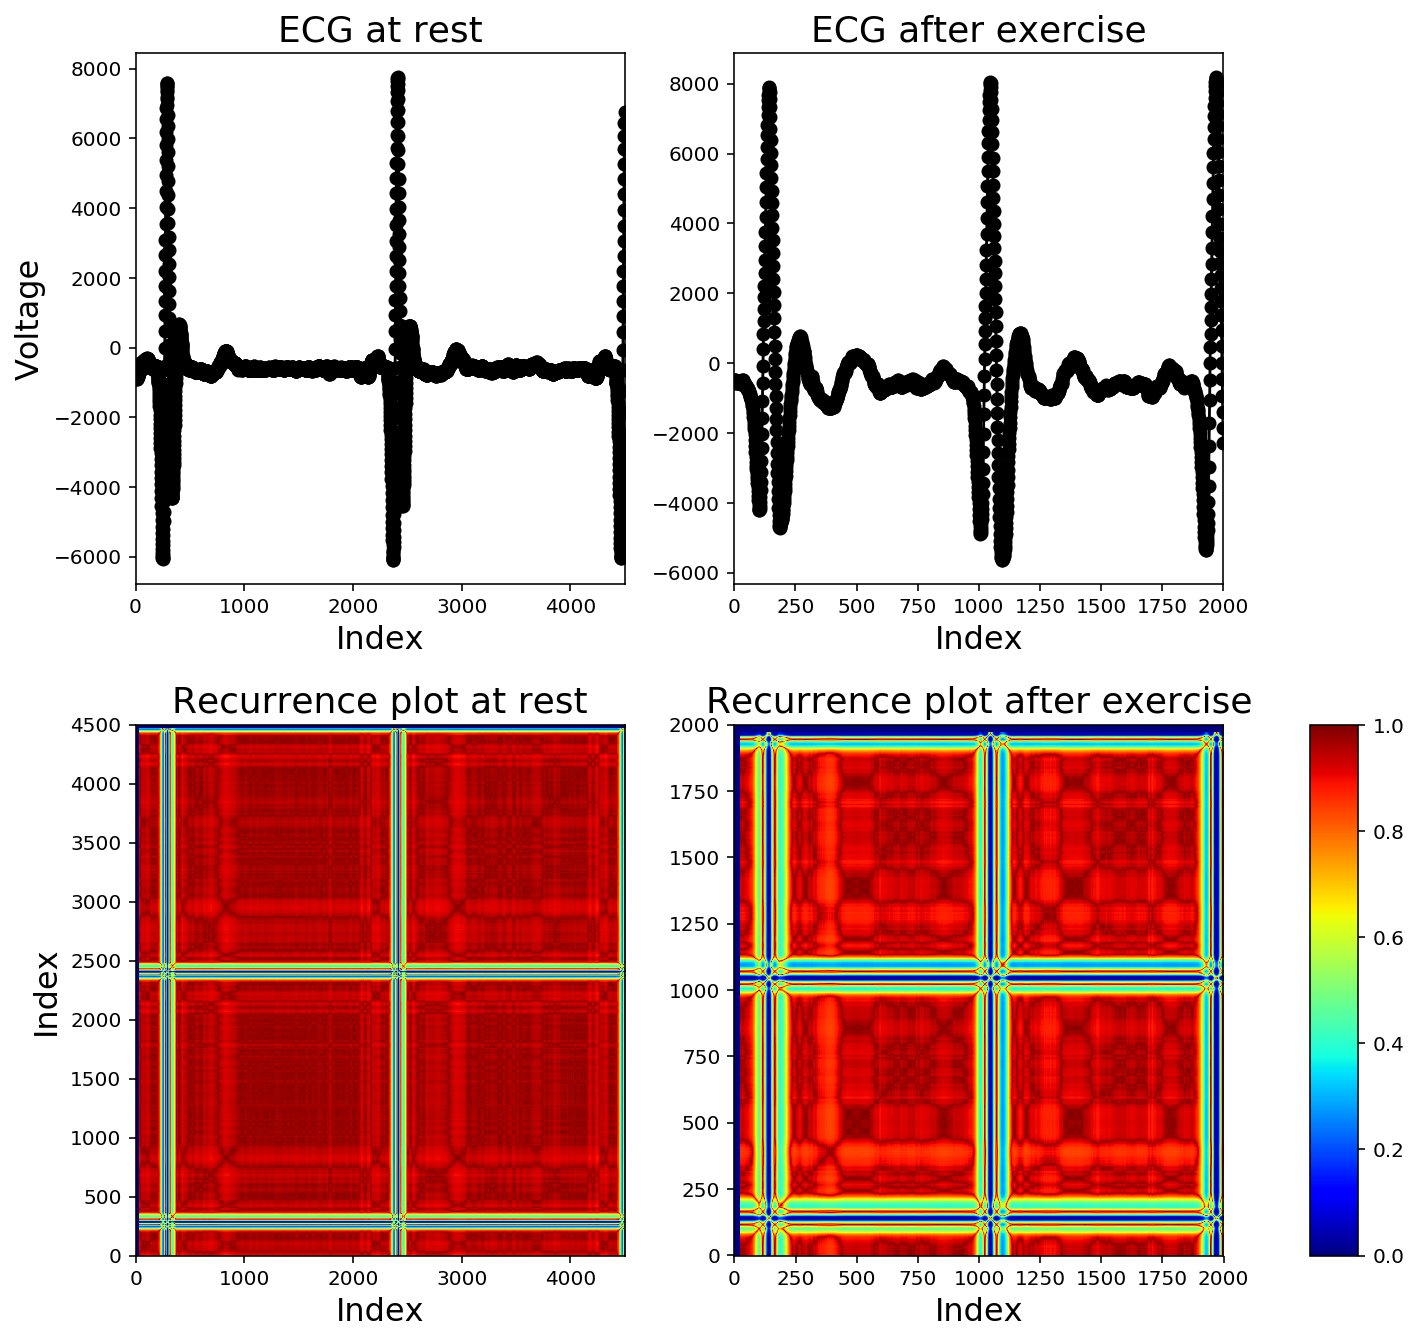

In [23]:
fig, axs = plt.subplots(2,2,figsize=(9,9))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], wspace=0.3, hspace=1)

axs[0, 0].plot(index_surrogate, surrogate, marker="o", c="k")
axs[0, 0].set_title("ECG at rest")
axs[0, 0].set_xlabel("Index")
axs[0, 0].set_ylabel("Voltage")
axs[0, 0].set_xlim(0, len(index_surrogate))

axs[0, 1].plot(index_surrogate_exer, surrogate_exer, marker="o", c="k")
axs[0, 1].set_title("ECG after exercise")
axs[0, 1].set_xlabel("Index")
axs[0, 1].set_xlim(0, len(index_surrogate_exer))

plot = axs[1, 0].imshow(normal_euclid_rest, origin='lower', aspect="auto", cmap="jet")
axs[1, 0].set_title("Recurrence plot at rest")
axs[1, 0].set_xlabel("Index")
axs[1, 0].set_ylabel("Index")
axins = inset_axes(axs[1,0],
               width="10%", # width = 10% of parent_bbox width
               height="100%", # height : 50%
               loc=6,
               bbox_to_anchor=(2.4, 0, 1, 1),
               bbox_transform=axs[1,0].transAxes,
               borderpad=0,)

axs[1, 1].imshow(normal_euclid_exer, origin='lower', aspect="auto", cmap="jet")
axs[1, 1].set_title("Recurrence plot after exercise")
axs[1, 1].set_xlabel("Index")

cbar = plt.colorbar(plot, cax=axins)
fig.tight_layout()
fig.subplots_adjust(top=1)

### Exercise: Compare the two previous recurrence plots: after doing exercise and at rest. What differences can you see?

Just in case you missed it, notice that after performing exercise, some kinds of patterns emerged in the red areas, when they did not exist in a resting state. Is this due to an artifact or is it because of the nature of the signal? Actually, in the ECG signal, we observe that the P and T waves have a higher amplitude after exercise than in the resting state. This is probably due to artifacts in the ECG.

If you compare the resting recurrence plot to the first image of: https://upload.wikimedia.org/wikipedia/commons/4/46/Rp_examples740.gif (Image taken from Norbert Marwan, Pucicu at English Wikipedia, CC BY-SA 3.0, 10 October 2006), you can find a resemblance with white noise. Since 1987, researchers have found "increasing evidence to suggest that the heart is not a periodic oscillator under normal physiologic conditions." Actually, a healthier heart has this random fluctuations, which make the recurrence plot more alike a recurrence plot of white noise. While a heart with an illness resembles more of a periodic oscilator. These dynamic changes can be observed when a heart is put under a stress trail. This kinds of analysis could be of help for medics, because an electrocardiogram is a non invasive technique, which could help identify patiens at risk.

You can find the previous cite in: Acharya, U. R., Joseph, K. P., Kannathal, N., Lim, C. M., & Suri, J. S. (2006). Heart rate variability: a review. Medical and biological engineering and computing, 44(12), 1031-1051.

Where it cites the following article: Goldberger, A. L., & West, B. J. (1987). Applications of nonlinear dynamics to clinical cardiology. Annals of the New York Academy of Sciences, 504, 195-213.

# References

Arce H. (2018, September) Presentation called: Variabilidad cardiaca y salud. Efecto de la fatiga. Available in Spanish at: https://www.youtube.com/watch?v=MKmjmtbRrqE

Acharya, U. R., Joseph, K. P., Kannathal, N., Lim, C. M., & Suri, J. S. (2006). Heart rate variability: a review. Medical and biological engineering and computing, 44(12), 1031-1051.

González, H., Infante, O., & Lerma, C. (2014). Response to active standing of heart beat interval, systolic blood volume and systolic blood pressure: recurrence plot analysis. In Translational Recurrences (pp. 109-123). Springer, Cham.

Gospodinova, E. (2019, September). GRAPHICAL METHODS FOR NON-LINEAR ANALYSIS OF ELECTROCARDIOGRAPHIC DATA. In CBU International Conference Proceedings (Vol. 7, pp. 864-869).

Marwan, N., Wessel, N., Meyerfeldt, U., Schirdewan, A., & Kurths, J. (2002). Recurrence-plot-based measures of complexity and their application to heart-rate-variability data. Physical review E, 66(2), 026702.

Mewett, D. T., Reynolds, K. J., & Nazeran, H. (1999, August). Recurrence plot features: An example using ECG. In ISSPA'99. Proceedings of the Fifth International Symposium on Signal Processing and its Applications (IEEE Cat. No. 99EX359) (Vol. 1, pp. 175-178). IEEE.

Mohebbi, M., Ghassemian, H., & Asl, B. M. (2011). Structures of the recurrence plot of heart rate variability signal as a tool for predicting the onset of paroxysmal atrial fibrillation. Journal of medical signals and sensors, 1(2), 113.

Nayak, S. K., Bit, A., Dey, A., Mohapatra, B., & Pal, K. (2018). A review on the nonlinear dynamical system analysis of electrocardiogram signal. Journal of healthcare engineering, 2018.

Sun, R., & Wang, Y. (2008). Predicting termination of atrial fibrillation based on the structure and quantification of the recurrence plot. Medical engineering & physics, 30(9), 1105-1111.

Webber Jr, C. L., & Zbilut, J. P. (1994). Dynamical assessment of physiological systems and states using recurrence plot strategies. Journal of applied physiology, 76(2), 965-973.